# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 73434915.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


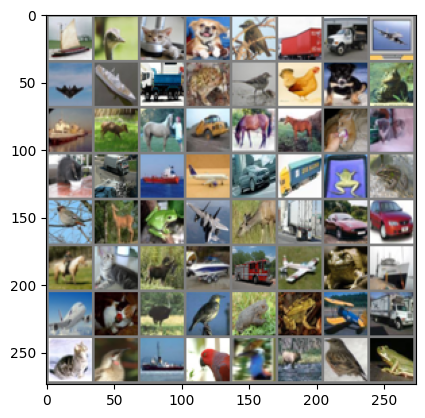

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

# Model - BN

In [6]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C3P1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # C4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 14

        # C7P2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 14
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7

        #C8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        # C9
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 3


        # C10
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 1


        # GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        # C11
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )




    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,024
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           4,608
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2657177448272705 Batch_id=781 Accuracy=39.26: 100%|██████████| 782/782 [00:38<00:00, 20.49it/s]



Test set: Average loss: 1.3816, Accuracy: 4914/10000 (49.14%)

EPOCH: 1


Loss=1.2649869918823242 Batch_id=781 Accuracy=52.09: 100%|██████████| 782/782 [00:24<00:00, 32.03it/s]



Test set: Average loss: 1.1984, Accuracy: 5630/10000 (56.30%)

EPOCH: 2


Loss=0.8041933178901672 Batch_id=781 Accuracy=57.41: 100%|██████████| 782/782 [00:27<00:00, 28.73it/s]



Test set: Average loss: 1.1014, Accuracy: 6070/10000 (60.70%)

EPOCH: 3


Loss=1.0380167961120605 Batch_id=781 Accuracy=60.36: 100%|██████████| 782/782 [00:26<00:00, 29.84it/s]



Test set: Average loss: 1.0102, Accuracy: 6385/10000 (63.85%)

EPOCH: 4


Loss=0.9538131356239319 Batch_id=781 Accuracy=62.28: 100%|██████████| 782/782 [00:25<00:00, 30.47it/s]



Test set: Average loss: 1.0080, Accuracy: 6384/10000 (63.84%)

EPOCH: 5


Loss=1.39425528049469 Batch_id=781 Accuracy=64.23: 100%|██████████| 782/782 [00:25<00:00, 31.04it/s]



Test set: Average loss: 0.9379, Accuracy: 6669/10000 (66.69%)

EPOCH: 6


Loss=0.8170177936553955 Batch_id=781 Accuracy=67.27: 100%|██████████| 782/782 [00:23<00:00, 33.07it/s]



Test set: Average loss: 0.8536, Accuracy: 6978/10000 (69.78%)

EPOCH: 7


Loss=1.0303375720977783 Batch_id=781 Accuracy=68.14: 100%|██████████| 782/782 [00:24<00:00, 32.42it/s]



Test set: Average loss: 0.8503, Accuracy: 6999/10000 (69.99%)

EPOCH: 8


Loss=1.8615319728851318 Batch_id=781 Accuracy=68.22: 100%|██████████| 782/782 [00:23<00:00, 33.34it/s]



Test set: Average loss: 0.8486, Accuracy: 7006/10000 (70.06%)

EPOCH: 9


Loss=1.5915920734405518 Batch_id=781 Accuracy=68.58: 100%|██████████| 782/782 [00:23<00:00, 33.68it/s]



Test set: Average loss: 0.8342, Accuracy: 7065/10000 (70.65%)

EPOCH: 10


Loss=0.612917959690094 Batch_id=781 Accuracy=69.08: 100%|██████████| 782/782 [00:23<00:00, 33.30it/s]



Test set: Average loss: 0.8316, Accuracy: 7037/10000 (70.37%)

EPOCH: 11


Loss=1.3175652027130127 Batch_id=781 Accuracy=69.17: 100%|██████████| 782/782 [00:23<00:00, 32.77it/s]



Test set: Average loss: 0.8318, Accuracy: 7038/10000 (70.38%)

EPOCH: 12


Loss=0.5999130010604858 Batch_id=781 Accuracy=69.69: 100%|██████████| 782/782 [00:23<00:00, 33.83it/s]



Test set: Average loss: 0.8206, Accuracy: 7110/10000 (71.10%)

EPOCH: 13


Loss=1.0593516826629639 Batch_id=781 Accuracy=69.81: 100%|██████████| 782/782 [00:23<00:00, 33.62it/s]



Test set: Average loss: 0.8289, Accuracy: 7045/10000 (70.45%)

EPOCH: 14


Loss=0.5244951248168945 Batch_id=781 Accuracy=69.63: 100%|██████████| 782/782 [00:23<00:00, 33.74it/s]



Test set: Average loss: 0.8308, Accuracy: 7047/10000 (70.47%)

EPOCH: 15


Loss=0.8739601373672485 Batch_id=781 Accuracy=69.77: 100%|██████████| 782/782 [00:23<00:00, 33.37it/s]



Test set: Average loss: 0.8151, Accuracy: 7133/10000 (71.33%)

EPOCH: 16


Loss=0.6458475589752197 Batch_id=781 Accuracy=69.58: 100%|██████████| 782/782 [00:23<00:00, 33.94it/s]



Test set: Average loss: 0.8182, Accuracy: 7106/10000 (71.06%)

EPOCH: 17


Loss=0.9652773141860962 Batch_id=781 Accuracy=69.69: 100%|██████████| 782/782 [00:22<00:00, 34.78it/s]



Test set: Average loss: 0.8266, Accuracy: 7053/10000 (70.53%)

EPOCH: 18


Loss=1.0746488571166992 Batch_id=781 Accuracy=69.84: 100%|██████████| 782/782 [00:21<00:00, 35.81it/s]



Test set: Average loss: 0.8159, Accuracy: 7112/10000 (71.12%)

EPOCH: 19


Loss=0.9785109758377075 Batch_id=781 Accuracy=69.75: 100%|██████████| 782/782 [00:22<00:00, 35.53it/s]



Test set: Average loss: 0.8219, Accuracy: 7077/10000 (70.77%)



Text(0.5, 1.0, 'Test Accuracy')

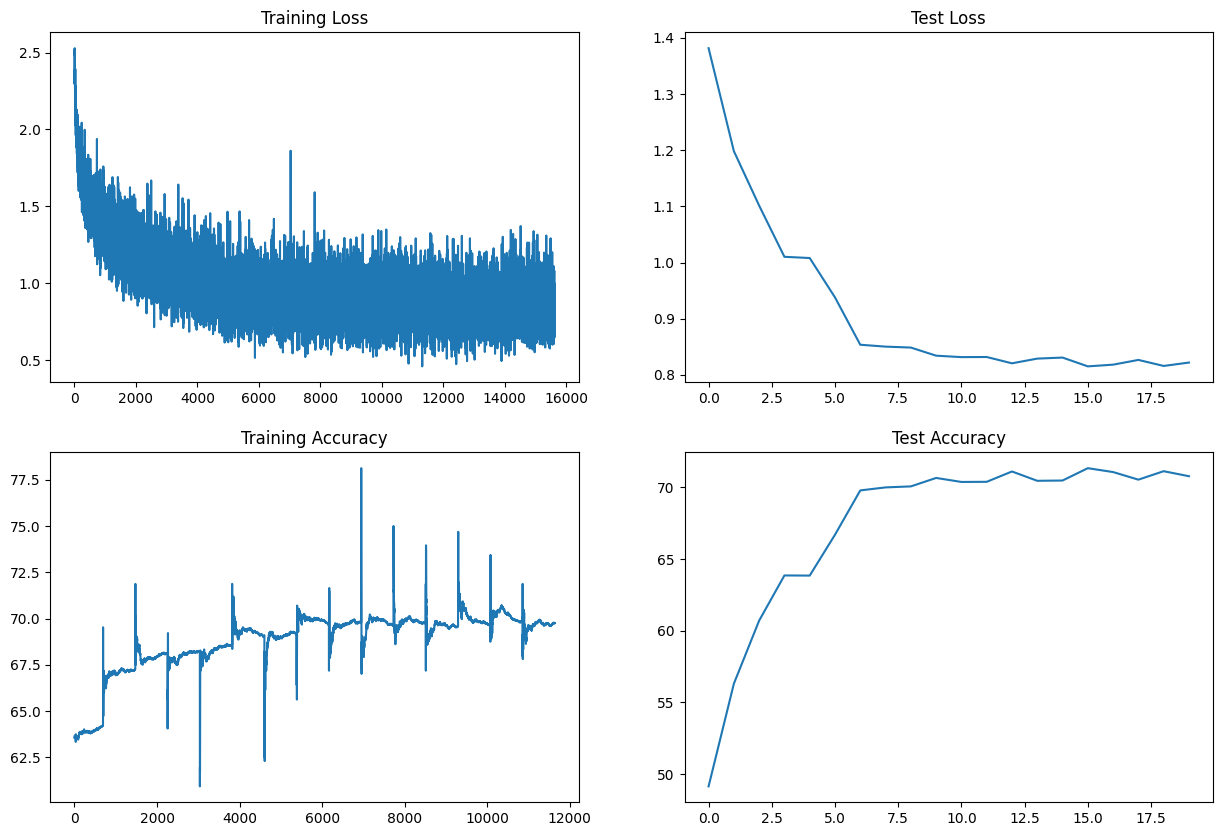

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Move train_losses tensor to CPU and convert to NumPy array
train_losses_np = [loss.cpu().item() for loss in train_losses]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_losses_np)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


In [14]:
torch.save(model.state_dict(), '/content/result/model_bn.pth')

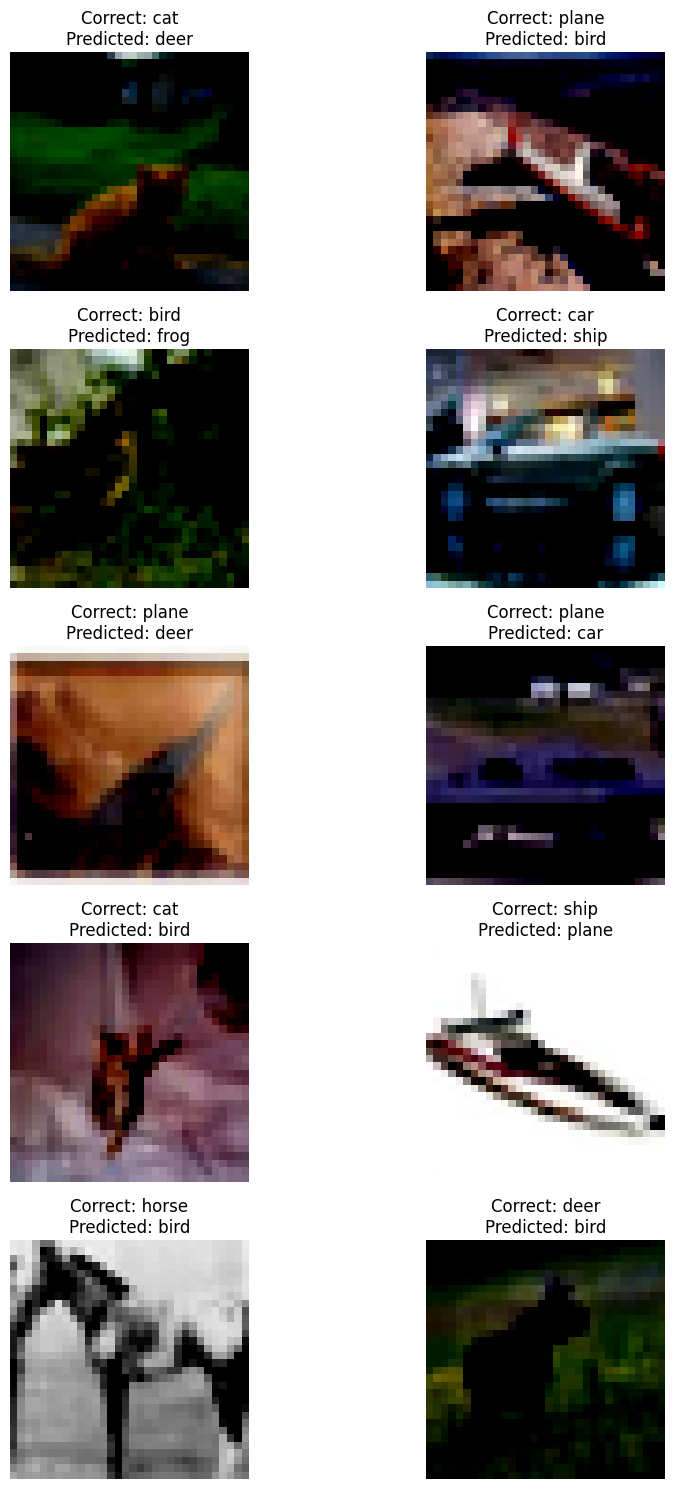

In [20]:
# Initialize the model and load trained weights
model = Net()
model_path = '/content/result/model_bn.pth'  # Update the path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Define classes in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to evaluate the model on the test set and find misclassified images
def find_misclassified_images():
    misclassified_images = []
    correct_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Convert predicted and labels tensors to numpy arrays for comparison
            predicted_np = predicted.numpy()
            labels_np = labels.numpy()
            # Compare element-wise for misclassification
            misclassified_indices = np.where(predicted_np != labels_np)[0]
            for idx in misclassified_indices:
                misclassified_images.append(images[idx])
                correct_labels.append(classes[labels_np[idx]])
                predicted_labels.append(classes[predicted_np[idx]])

    return misclassified_images[:10], correct_labels[:10], predicted_labels[:10]


# Find misclassified images
misclassified_images, correct_labels, predicted_labels = find_misclassified_images()

# Display misclassified images
num_images = len(misclassified_images)
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(misclassified_images[i].squeeze().numpy(), (1, 2, 0)))
    ax.set_title(f'Correct: {correct_labels[i]}\nPredicted: {predicted_labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()



-------------------------------------------------------------



Model - GN

In [34]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C3P1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # C4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(dropout_value)
        ) # output_size = 14

        # C7P2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 14
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7

        #C8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        # C9
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 3

        # C10
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        # GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        # C11
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [35]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net2().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,024
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [36]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [37]:
from torch.optim.lr_scheduler import StepLR

model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.9088647365570068 Batch_id=781 Accuracy=22.49: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s]



Test set: Average loss: 1.8910, Accuracy: 3026/10000 (30.26%)

EPOCH: 1


Loss=1.6660783290863037 Batch_id=781 Accuracy=29.24: 100%|██████████| 782/782 [00:23<00:00, 33.26it/s]



Test set: Average loss: 1.7743, Accuracy: 3381/10000 (33.81%)

EPOCH: 2


Loss=1.6767667531967163 Batch_id=781 Accuracy=34.73: 100%|██████████| 782/782 [00:24<00:00, 32.48it/s]



Test set: Average loss: 1.6756, Accuracy: 3737/10000 (37.37%)

EPOCH: 3


Loss=1.5783416032791138 Batch_id=781 Accuracy=39.35: 100%|██████████| 782/782 [00:24<00:00, 31.95it/s]



Test set: Average loss: 1.8114, Accuracy: 3505/10000 (35.05%)

EPOCH: 4


Loss=1.3894463777542114 Batch_id=781 Accuracy=41.75: 100%|██████████| 782/782 [00:25<00:00, 30.82it/s]



Test set: Average loss: 1.5094, Accuracy: 4531/10000 (45.31%)

EPOCH: 5


Loss=1.1924645900726318 Batch_id=781 Accuracy=45.36: 100%|██████████| 782/782 [00:24<00:00, 32.32it/s]



Test set: Average loss: 1.4113, Accuracy: 4863/10000 (48.63%)

EPOCH: 6


Loss=1.1264350414276123 Batch_id=781 Accuracy=50.07: 100%|██████████| 782/782 [00:24<00:00, 32.41it/s]



Test set: Average loss: 1.3472, Accuracy: 5173/10000 (51.73%)

EPOCH: 7


Loss=1.4947651624679565 Batch_id=781 Accuracy=50.83: 100%|██████████| 782/782 [00:24<00:00, 31.91it/s]



Test set: Average loss: 1.3258, Accuracy: 5263/10000 (52.63%)

EPOCH: 8


Loss=1.1404218673706055 Batch_id=781 Accuracy=51.48: 100%|██████████| 782/782 [00:24<00:00, 32.53it/s]



Test set: Average loss: 1.3171, Accuracy: 5276/10000 (52.76%)

EPOCH: 9


Loss=1.4736294746398926 Batch_id=781 Accuracy=52.05: 100%|██████████| 782/782 [00:24<00:00, 32.12it/s]



Test set: Average loss: 1.3151, Accuracy: 5293/10000 (52.93%)

EPOCH: 10


Loss=0.8928442001342773 Batch_id=781 Accuracy=52.67: 100%|██████████| 782/782 [00:25<00:00, 31.10it/s]



Test set: Average loss: 1.2917, Accuracy: 5350/10000 (53.50%)

EPOCH: 11


Loss=1.4239978790283203 Batch_id=781 Accuracy=53.18: 100%|██████████| 782/782 [00:24<00:00, 31.67it/s]



Test set: Average loss: 1.2873, Accuracy: 5377/10000 (53.77%)

EPOCH: 12


Loss=0.9959473013877869 Batch_id=781 Accuracy=54.04: 100%|██████████| 782/782 [00:24<00:00, 31.45it/s]



Test set: Average loss: 1.2765, Accuracy: 5428/10000 (54.28%)

EPOCH: 13


Loss=1.2908803224563599 Batch_id=781 Accuracy=54.09: 100%|██████████| 782/782 [00:24<00:00, 31.28it/s]



Test set: Average loss: 1.2757, Accuracy: 5423/10000 (54.23%)

EPOCH: 14


Loss=1.2033319473266602 Batch_id=781 Accuracy=53.89: 100%|██████████| 782/782 [00:24<00:00, 31.98it/s]



Test set: Average loss: 1.2782, Accuracy: 5420/10000 (54.20%)

EPOCH: 15


Loss=1.7623454332351685 Batch_id=781 Accuracy=53.98: 100%|██████████| 782/782 [00:25<00:00, 31.24it/s]



Test set: Average loss: 1.2779, Accuracy: 5411/10000 (54.11%)

EPOCH: 16


Loss=1.0729639530181885 Batch_id=781 Accuracy=54.18: 100%|██████████| 782/782 [00:24<00:00, 31.47it/s]



Test set: Average loss: 1.2655, Accuracy: 5458/10000 (54.58%)

EPOCH: 17


Loss=1.2859210968017578 Batch_id=781 Accuracy=54.21: 100%|██████████| 782/782 [00:24<00:00, 31.58it/s]



Test set: Average loss: 1.2697, Accuracy: 5445/10000 (54.45%)

EPOCH: 18


Loss=1.1901525259017944 Batch_id=781 Accuracy=54.34: 100%|██████████| 782/782 [00:25<00:00, 31.23it/s]



Test set: Average loss: 1.2673, Accuracy: 5453/10000 (54.53%)

EPOCH: 19


Loss=1.5004578828811646 Batch_id=781 Accuracy=54.46: 100%|██████████| 782/782 [00:24<00:00, 31.30it/s]



Test set: Average loss: 1.2679, Accuracy: 5452/10000 (54.52%)



Text(0.5, 1.0, 'Test Accuracy')

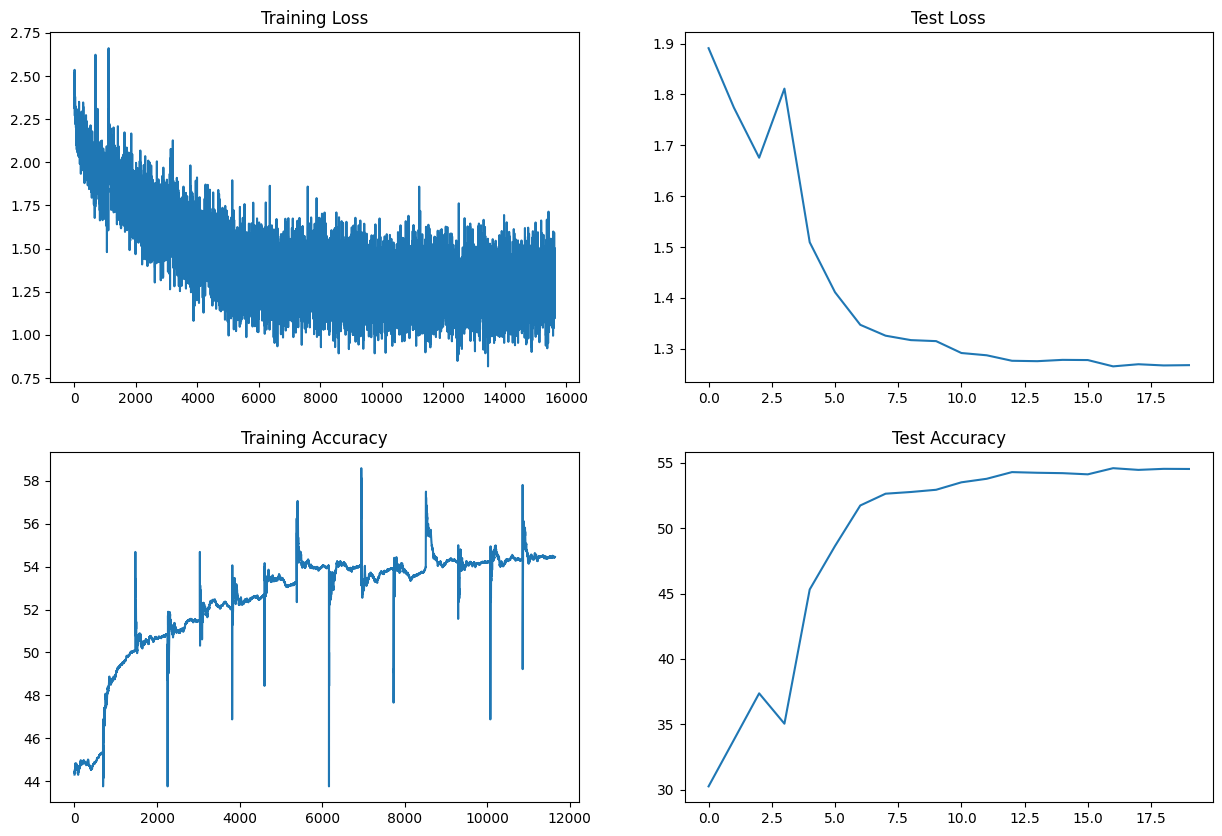

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

# Move train_losses tensor to CPU and convert to NumPy array
train_losses_np = [loss.cpu().item() for loss in train_losses]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_losses_np)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [39]:
torch.save(model.state_dict(), '/content/result/model_gn.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


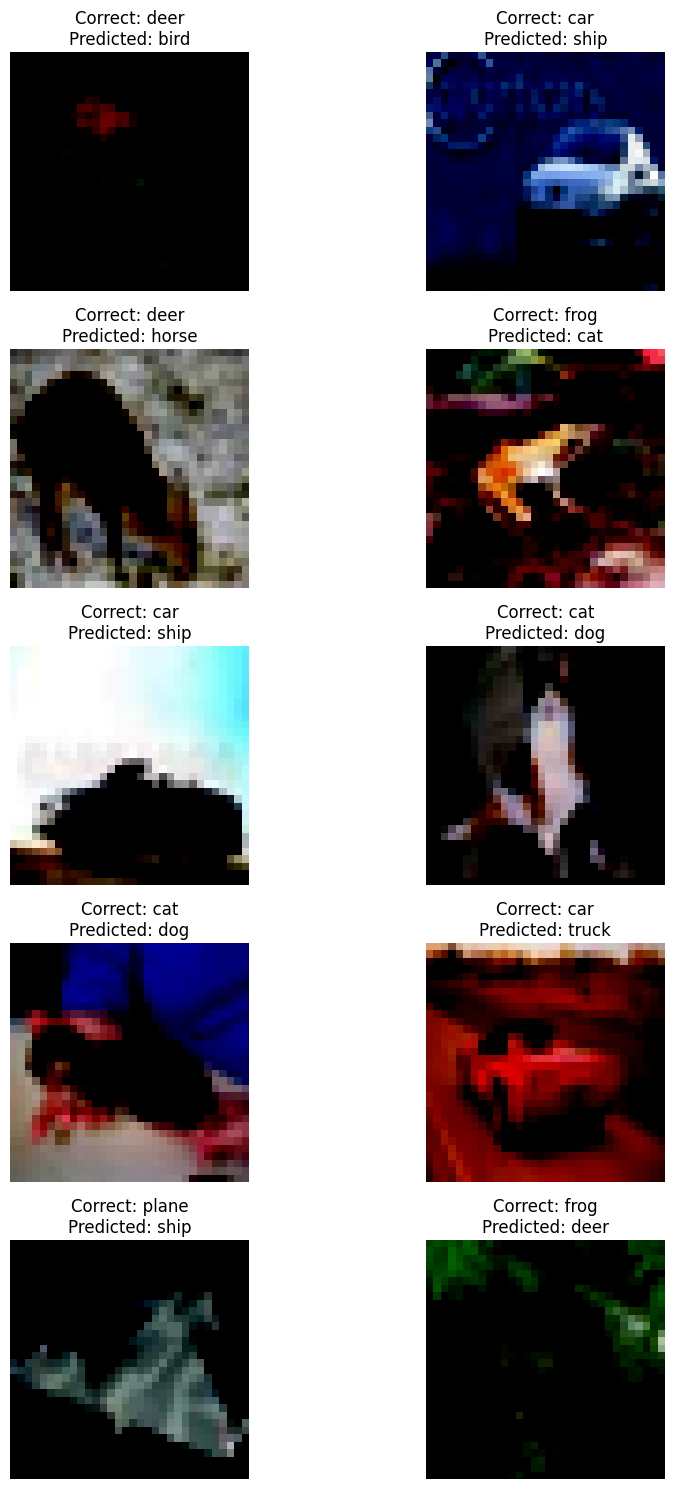

In [45]:
# Initialize the model and load trained weights
model = Net2()
model_path = '/content/result/model_gn.pth'  # Update the path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Define classes in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to evaluate the model on the test set and find misclassified images
def find_misclassified_images():
    misclassified_images = []
    correct_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Convert predicted and labels tensors to numpy arrays for comparison
            predicted_np = predicted.numpy()
            labels_np = labels.numpy()
            # Compare element-wise for misclassification
            misclassified_indices = np.where(predicted_np != labels_np)[0]
            for idx in misclassified_indices:
                misclassified_images.append(images[idx])
                correct_labels.append(classes[labels_np[idx]])
                predicted_labels.append(classes[predicted_np[idx]])

    return misclassified_images[:10], correct_labels[:10], predicted_labels[:10]


# Find misclassified images
misclassified_images, correct_labels, predicted_labels = find_misclassified_images()

# Display misclassified images
num_images = len(misclassified_images)
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(misclassified_images[i].squeeze().numpy(), (1, 2, 0)))
    ax.set_title(f'Correct: {correct_labels[i]}\nPredicted: {predicted_labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


-------------------------------------------------------------


Model - LN

In [53]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([4, 32, 32]),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([4, 32, 32]),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # C3P1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # C4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 16, 16]),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 16, 16]),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        # C6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 14, 14]),
            nn.Dropout(dropout_value)
        ) # output_size = 14

        # C7P2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 14
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7

        #C8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 5, 5]),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        # C9
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 3, 3]),
            nn.Dropout(dropout_value)
        ) # output_size = 3

        # C10
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 1, 1]),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        # GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        # C11
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [54]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net3().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             108
              ReLU-2            [-1, 4, 32, 32]               0
         LayerNorm-3            [-1, 4, 32, 32]           8,192
           Dropout-4            [-1, 4, 32, 32]               0
            Conv2d-5            [-1, 4, 32, 32]             144
              ReLU-6            [-1, 4, 32, 32]               0
         LayerNorm-7            [-1, 4, 32, 32]           8,192
           Dropout-8            [-1, 4, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]              32
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
             ReLU-12           [-1, 16, 16, 16]               0
        LayerNorm-13           [-1, 16, 16, 16]           8,192
          Dropout-14           [-1

In [55]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.508437991142273 Batch_id=781 Accuracy=30.08: 100%|██████████| 782/782 [00:24<00:00, 31.59it/s]



Test set: Average loss: 1.6420, Accuracy: 3871/10000 (38.71%)

EPOCH: 1


Loss=1.3585517406463623 Batch_id=781 Accuracy=40.85: 100%|██████████| 782/782 [00:20<00:00, 37.65it/s]



Test set: Average loss: 1.4968, Accuracy: 4537/10000 (45.37%)

EPOCH: 2


Loss=1.3399611711502075 Batch_id=781 Accuracy=46.28: 100%|██████████| 782/782 [00:20<00:00, 37.63it/s]



Test set: Average loss: 1.4070, Accuracy: 4851/10000 (48.51%)

EPOCH: 3


Loss=1.3032262325286865 Batch_id=781 Accuracy=51.23: 100%|██████████| 782/782 [00:20<00:00, 38.28it/s]



Test set: Average loss: 1.2266, Accuracy: 5582/10000 (55.82%)

EPOCH: 4


Loss=1.0005582571029663 Batch_id=781 Accuracy=55.39: 100%|██████████| 782/782 [00:20<00:00, 38.82it/s]



Test set: Average loss: 1.1511, Accuracy: 5821/10000 (58.21%)

EPOCH: 5


Loss=1.331091046333313 Batch_id=781 Accuracy=58.00: 100%|██████████| 782/782 [00:20<00:00, 38.47it/s]



Test set: Average loss: 1.1162, Accuracy: 6051/10000 (60.51%)

EPOCH: 6


Loss=1.493127703666687 Batch_id=781 Accuracy=62.33: 100%|██████████| 782/782 [00:20<00:00, 38.52it/s]



Test set: Average loss: 1.0071, Accuracy: 6368/10000 (63.68%)

EPOCH: 7


Loss=1.1716763973236084 Batch_id=781 Accuracy=62.90: 100%|██████████| 782/782 [00:20<00:00, 37.67it/s]



Test set: Average loss: 0.9853, Accuracy: 6488/10000 (64.88%)

EPOCH: 8


Loss=0.5338844656944275 Batch_id=781 Accuracy=63.10: 100%|██████████| 782/782 [00:21<00:00, 35.82it/s]



Test set: Average loss: 0.9826, Accuracy: 6471/10000 (64.71%)

EPOCH: 9


Loss=1.464418888092041 Batch_id=781 Accuracy=63.88: 100%|██████████| 782/782 [00:22<00:00, 35.08it/s]



Test set: Average loss: 0.9754, Accuracy: 6504/10000 (65.04%)

EPOCH: 10


Loss=1.1535264253616333 Batch_id=781 Accuracy=64.16: 100%|██████████| 782/782 [00:20<00:00, 37.61it/s]



Test set: Average loss: 0.9639, Accuracy: 6586/10000 (65.86%)

EPOCH: 11


Loss=0.9474532008171082 Batch_id=781 Accuracy=64.41: 100%|██████████| 782/782 [00:21<00:00, 36.74it/s]



Test set: Average loss: 0.9463, Accuracy: 6629/10000 (66.29%)

EPOCH: 12


Loss=0.5433407425880432 Batch_id=781 Accuracy=64.87: 100%|██████████| 782/782 [00:21<00:00, 36.72it/s]



Test set: Average loss: 0.9438, Accuracy: 6648/10000 (66.48%)

EPOCH: 13


Loss=0.5403723120689392 Batch_id=781 Accuracy=64.83: 100%|██████████| 782/782 [00:21<00:00, 36.27it/s]



Test set: Average loss: 0.9420, Accuracy: 6650/10000 (66.50%)

EPOCH: 14


Loss=1.1735343933105469 Batch_id=781 Accuracy=65.23: 100%|██████████| 782/782 [00:21<00:00, 36.35it/s]



Test set: Average loss: 0.9418, Accuracy: 6663/10000 (66.63%)

EPOCH: 15


Loss=0.8701025247573853 Batch_id=781 Accuracy=65.11: 100%|██████████| 782/782 [00:21<00:00, 36.22it/s]



Test set: Average loss: 0.9401, Accuracy: 6670/10000 (66.70%)

EPOCH: 16


Loss=1.1405186653137207 Batch_id=781 Accuracy=65.19: 100%|██████████| 782/782 [00:21<00:00, 37.24it/s]



Test set: Average loss: 0.9381, Accuracy: 6666/10000 (66.66%)

EPOCH: 17


Loss=1.0497111082077026 Batch_id=781 Accuracy=65.00: 100%|██████████| 782/782 [00:21<00:00, 37.11it/s]



Test set: Average loss: 0.9381, Accuracy: 6657/10000 (66.57%)

EPOCH: 18


Loss=0.7595648765563965 Batch_id=781 Accuracy=65.17: 100%|██████████| 782/782 [00:21<00:00, 36.69it/s]



Test set: Average loss: 0.9378, Accuracy: 6668/10000 (66.68%)

EPOCH: 19


Loss=0.8927760720252991 Batch_id=781 Accuracy=65.10: 100%|██████████| 782/782 [00:22<00:00, 34.75it/s]



Test set: Average loss: 0.9374, Accuracy: 6668/10000 (66.68%)



Text(0.5, 1.0, 'Test Accuracy')

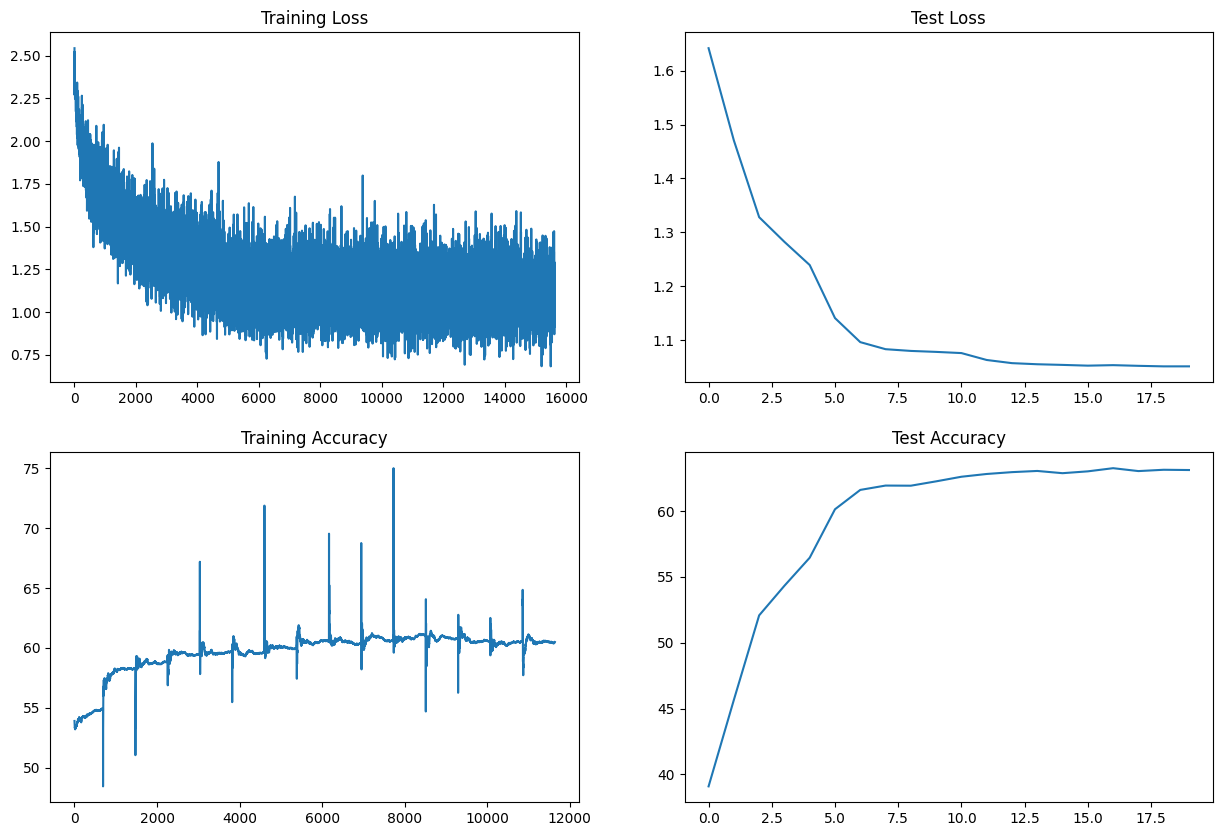

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# Move train_losses tensor to CPU and convert to NumPy array
train_losses_np = [loss.cpu().item() for loss in train_losses]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(train_losses_np)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [59]:
torch.save(model.state_dict(), '/content/result/model_ln.pth')

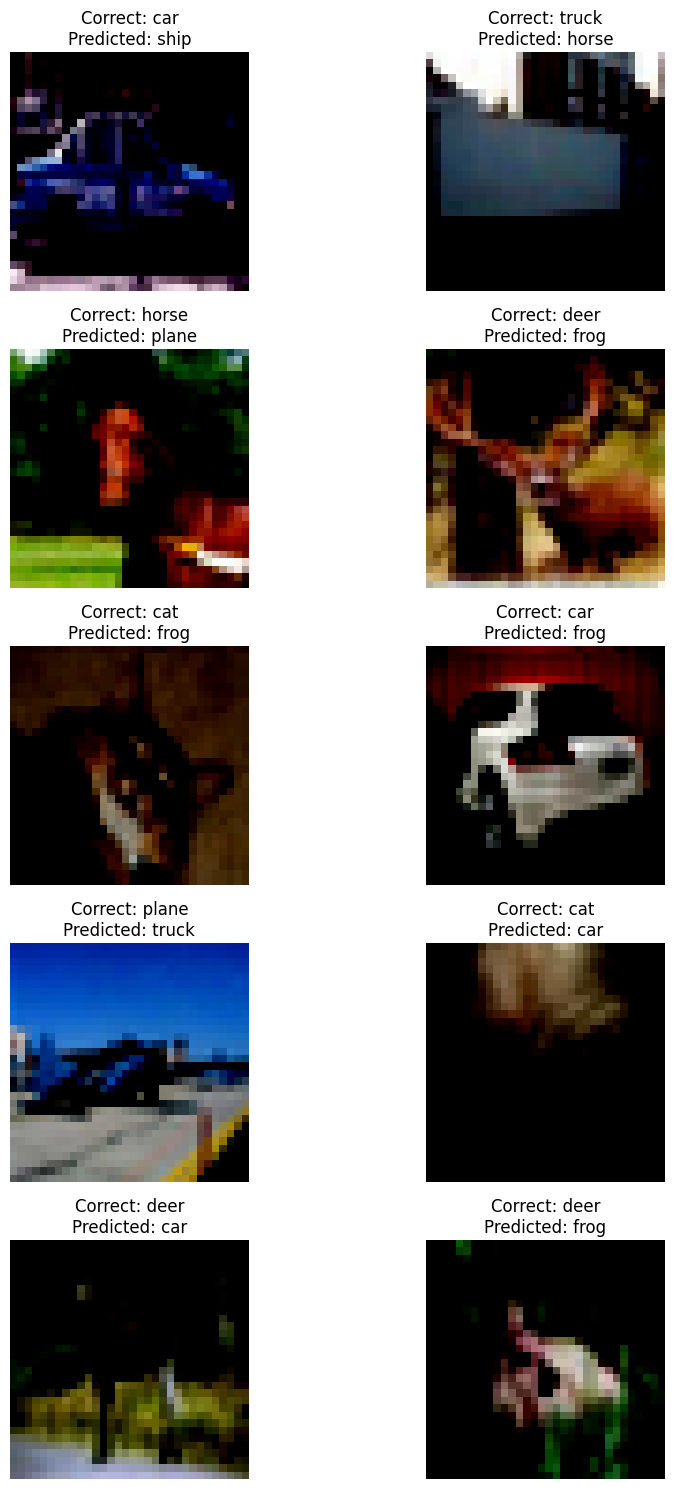

In [61]:
# Initialize the model and load trained weights
model = Net2()
model_path = '/content/result/model_ln.pth'  # Update the path
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Define classes in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to evaluate the model on the test set and find misclassified images
def find_misclassified_images():
    misclassified_images = []
    correct_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Convert predicted and labels tensors to numpy arrays for comparison
            predicted_np = predicted.numpy()
            labels_np = labels.numpy()
            # Compare element-wise for misclassification
            misclassified_indices = np.where(predicted_np != labels_np)[0]
            for idx in misclassified_indices:
                misclassified_images.append(images[idx])
                correct_labels.append(classes[labels_np[idx]])
                predicted_labels.append(classes[predicted_np[idx]])

    return misclassified_images[:10], correct_labels[:10], predicted_labels[:10]


# Find misclassified images
misclassified_images, correct_labels, predicted_labels = find_misclassified_images()

# Display misclassified images
num_images = len(misclassified_images)
rows = 5
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(misclassified_images[i].squeeze().numpy(), (1, 2, 0)))
    ax.set_title(f'Correct: {correct_labels[i]}\nPredicted: {predicted_labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()
